In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes = bikes.dropna()

In [12]:
# dteday - no clue
# season - one hot
# hr - zscore?
# holiday - zero or one already
# workingday - zero or one already
# weathersit - one hot
# temp_c - zscore
# feels_like_c - zscore
# casual - zscore
# registered - zscore
if 'season' in bikes.columns or 'weathersit' in bikes.columns:
  bikes['season'] = bikes['season'].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'})

  bikes['weathersit'] = bikes['weathersit'].map({
      1: 'Clear, Few clouds, Partly cloudy', 
      2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 
      3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
      4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
      })
  # Normalizing the input
  bikes = pd.get_dummies(bikes, prefix='', prefix_sep='')

In [13]:
# Making an output column
bikes['total_users'] = bikes['casual'] + bikes['registered']
# Getting values for the model
if 'dteday' in bikes.columns:
  bikes.pop('dteday')
if 'instant'in bikes.columns:
  bikes.pop('instant')
bikes_features = bikes.copy()
bikes_label = bikes_features.pop('total_users')
normalize = preprocessing.Normalization()
normalize.adapt(np.array(bikes_features))
train_features, test_features, train_labels, test_labels = train_test_split(bikes_features, bikes_label, test_size=0.25)

In [21]:
norm_bikes_model = tf.keras.Sequential([
                                        normalize,
                                        layers.Dense(18, activation='relu'),
                                        layers.Dropout(0.1),
                                        layers.Dense(18, activation='relu'),
                                        layers.Dropout(0.4),
                                        layers.Dense(1, activation='linear'),
])
norm_bikes_model.compile(
    loss = 'mean_absolute_error',
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
norm_bikes_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 749)               1499      
_________________________________________________________________
dense_9 (Dense)              (None, 18)                13500     
_________________________________________________________________
dropout_6 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_7 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 19        
Total params: 15,360
Trainable params: 13,861
Non-trainable params: 1,499
______________________________________________

In [22]:
%%time
history = norm_bikes_model.fit(
    train_features, train_labels,
    validation_split = 0.2,
    verbose=0, epochs=200
)

CPU times: user 2min 26s, sys: 10.6 s, total: 2min 37s
Wall time: 1min 40s


In [31]:
score = norm_bikes_model.evaluate(test_features, test_labels)
ypred = norm_bikes_model.predict(test_features).flatten()
print(score)

136/136 [==============================] - 0s 1ms/step - loss: 13.3864 - accuracy: 0.0083
[13.386354446411133, 0.008285385556519032]


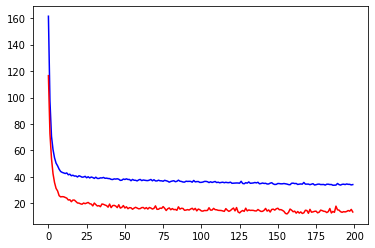

In [28]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()

(array([ 1.,  3., 13., 12., 34., 35., 23., 26., 17., 36.]),
 array([0.00652153, 0.00678047, 0.00703942, 0.00729836, 0.0075573 ,
        0.00781625, 0.00807519, 0.00833413, 0.00859308, 0.00885202,
        0.00911096]),
 <a list of 10 Patch objects>)

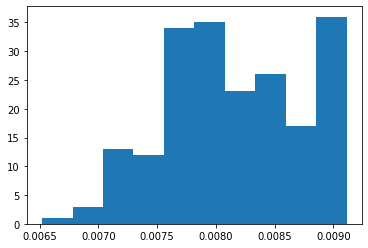

In [29]:
plt.hist(history.history['accuracy'])

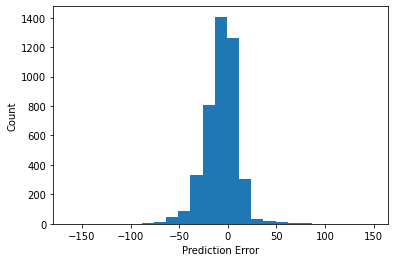

In [32]:
error = ypred - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')